Работа осуществляется с базой акции лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда. Используйте только столбец close и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой

# Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical 
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подготовка данных

In [ ]:
base_data16 = pd.read_csv('/content/drive/MyDrive/Lessons/Lesson7/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/MyDrive/Lessons/Lesson7/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data16_17.shape

(263925, 5)

In [ ]:
d = data18_19
print(len(d))
print(len(d.iloc[0]))
print(d.iloc[0])

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
data = data16_17.copy()
data = pd.concat([data16_17,data18_19])
data = np.array(data)

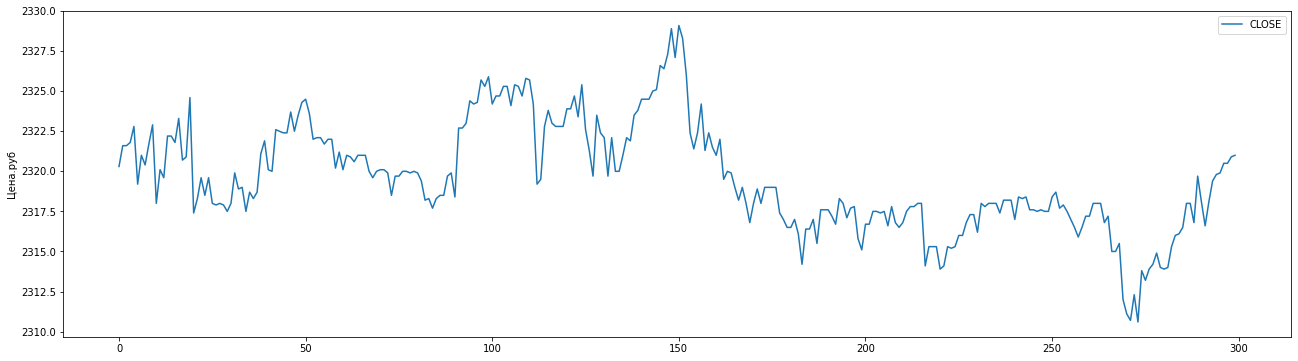

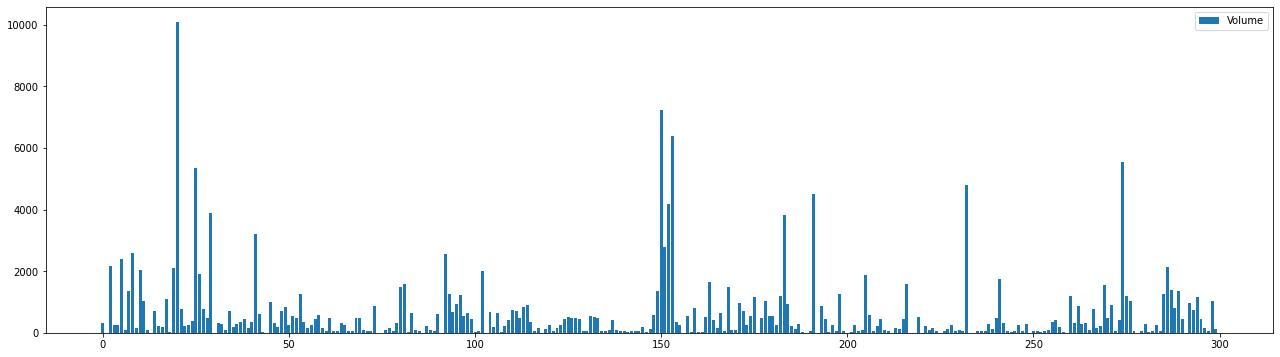

In [ ]:
start = 100
length = 300

chanelNames = ['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME']

plt.figure(figsize=(22,6))
plt.plot(data[start:start+length,3], 
          label=chanelNames[3])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

plt.figure(figsize=(22,6))
plt.bar(x=np.arange(length), height=data[start:start+length,4], label="Volume")
plt.legend()
plt.show()

# Вспомогательные функции

## Предсказание и вывод в начальном виде

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predict_y = currModel.predict(xVal)
  predVal = yScaler.inverse_transform(predict_y)
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

## Таблица ошибки при обучении

In [ ]:
def show_loss(history):
  plt.figure(figsize=(14,7))
  plt.plot(history.history['loss'], 
          label='Средняя абсолютная ошибка на обучающем наборе')
  plt.plot(history.history['val_loss'], 
          label='Средняя абсолютная ошибка на проверочном наборе')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()

## Проверка корреляции данных

In [ ]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa != 0) & (sb != 0)):
    val = (mab-ma*mb) / (sa*sb)

  return val

## Вывод корреляции

In [ ]:
def showCorr(channels, corrSteps, predVal, yValUnscaled):

  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0]

    for i in range(corrSteps):

      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = []

     
    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+10) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

## График предсказанного и реального

In [ ]:
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

## Создание полносвязной модели

In [ ]:
def create_dense_model(xLen=300, steps=1):
  modelD = Sequential()
  modelD.add(Dense(150, input_shape = (xLen, 1), activation="relu" ))
  modelD.add(Flatten())
  modelD.add(Dense(steps, activation="linear"))

  modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

  modelD.summary()

  return modelD

## Создание сверточной модели

In [ ]:
def create_conv_model(xLen=300, steps=1):
  modelC = Sequential()

  modelC.add(Conv1D(16, 5, input_shape = (xLen, 1), activation="relu"))
  modelC.add(Conv1D(8, 5, activation="relu"))
  modelC.add(MaxPooling1D())
  modelC.add(Flatten())
  modelC.add(Dense(100, activation="relu"))
  modelC.add(Dense(steps, activation="linear"))

  modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

  modelC.summary()

  return modelC

## Создание выборок для обучения и проверки

In [ ]:
def get_generator(xTrain, xTest, yTrain, yTest, xLen=300):
  xScaler = MinMaxScaler()
  xScaler.fit(xTrain)

  yScaler = MinMaxScaler()
  yScaler.fit(yTrain)

  xTrain = xScaler.transform(xTrain)
  xTest = xScaler.transform(xTest)
  
  yTrain = yScaler.transform(yTrain)
  yTest = yScaler.transform(yTest)

  trainDataGen = TimeseriesGenerator(xTrain, yTrain, 
                                length=xLen, stride=1, sampling_rate=1,
                                batch_size=20)


  testDataGen = TimeseriesGenerator(xTest, yTest,
                                length=xLen, stride=1,
                                batch_size=20)
  
  return [trainDataGen, testDataGen, xScaler, yScaler]

## Создание тестирующей выборки

In [ ]:
def get_validation(xTest, yTest, xScaler, yScaler):
  
  xTest = xScaler.transform(xTest)
  yTest = yScaler.transform(yTest)
  
  DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300,
                               batch_size=len(xTest))
  xVal = []
  yVal = []
  for i in DataGen:
    xVal.append(i[0])
    yVal.append(i[1])

  xVal = np.array(xVal)
  yVal = np.array(yVal)
  return [xVal, yVal]

## Получение данных

In [ ]:
def get_data(data, xLen=300, valLen=30000):

  trainLen = data.shape[0]-valLen

  xTrain, xTest = len(data[:trainLen, 3]), len(data[trainLen + 2 * xLen:-xLen, 3])

  xTrain = data[:trainLen, 3].reshape(xTrain, 1)
  xTest = data[trainLen + 2 * xLen: - xLen, 3].reshape(xTest, 1)

  yTrain = np.reshape(data[xLen:trainLen + xLen, 3], (-1, 1))
  yTest = np.reshape(data[trainLen + 3 * xLen:, 3], (-1, 1))

  generator = get_generator(xTrain, xTest, yTrain, yTest)
  trainDataGen, testDataGen = generator[0], generator[1]
  xScaler, yScaler = generator[2], generator[3]

  return [[trainDataGen, testDataGen, xScaler, yScaler],
          get_validation(xTest, yTest, xScaler, yScaler)]


In [ ]:
def transform(data_list):
  new_list = list()
  for ii in range(len(a[0])):
    d = list()
    for jj in range(len(a)):
      d.append(a[jj][ii])
    new_list.append(d)
  return new_list

## Получение данных на несколько шагов

In [ ]:
def get_data_few_steps(data, start=10, xLen=300, valLen=30000):
  yTrain, yTest = list(), list()

  trainLen = data.shape[0] - valLen

  xTrain = len(data[:trainLen, 3])
  xTest = len(data[trainLen + 2 *xLen:-start - xLen, 3])

  xTrain = data[:trainLen, 3].reshape(xTrain, 1)
  xTest = data[trainLen + 2 * xLen:-start - xLen, 3].reshape(xTest, 1)

  for i in range(len(xTrain)):
    yTrain.append(data[xLen + i:xLen + i + start, 3])

  for j in range(len(xTest)):
    yTest.append(data[trainLen + j + 3 * xLen:trainLen + j + 3 * xLen + start, 3])

  yTrain = np.reshape(yTrain, (-1, 10))
  yTest = np.reshape(yTest, (-1, 10))

  generator = get_generator(xTrain, xTest, yTrain, yTest)
  trainDataGen, testDataGen = generator[0], generator[1]
  xScaler, yScaler = generator[2], generator[3]

  return [[trainDataGen, testDataGen, xScaler, yScaler],
          get_validation(xTest, yTest, xScaler, yScaler)]

## Перевод данных в удобную для графика форму

In [ ]:
def transform(data_list, graph_len):
  new_list = list()
  for ii in range(data_list.shape[1]):
    if ii == graph_len:
      break
    d = list()
    for jj in range(data_list.shape[0]):
      d.append(data_list[jj][ii])
    new_list.append(d)
  return new_list

In [ ]:
d = get_data_few_steps(data)

# Эксперимент 1 - Полносвязная сеть (только столбец close)

In [ ]:
train_data = get_data(data)

# get Datagen for train and test
trainDataGen, testDataGen = train_data[0][0], train_data[0][1]

# get scaler
xScaler, yScaler = train_data[0][2], train_data[0][3]

# get validation data
xVal, yVal = train_data[1][0], train_data[1][1]

## Обучение модели

In [ ]:
# create new model
model = create_dense_model()

# learning model
history = model.fit(
                    trainDataGen, 
                    epochs=10, 
                    verbose=1, 
                    validation_data = testDataGen, 
                    )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 300, 150)          300       
                                                                 
 flatten_4 (Flatten)         (None, 45000)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 45001     
                                                                 
Total params: 45,301
Trainable params: 45,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22579/22579 [==============================] - 200s 9ms/step - loss: 7.1439e-04 - val_loss: 0.0011
Epoch 2/10
22579/22579 [==============================] - 189s 8ms/step - loss: 2.0162e-04 - val_loss: 2.8062e-04
Epoch 3/10
22579/22579 [==============================] - 186s 8ms/step - loss: 1.6361e-04

In [ ]:
model = create_dense_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 300, 150)          300       
                                                                 
 flatten_5 (Flatten)         (None, 45000)             0         
                                                                 
 dense_11 (Dense)            (None, 1)                 45001     
                                                                 
Total params: 45,301
Trainable params: 45,301
Non-trainable params: 0
_________________________________________________________________


## График ошибок

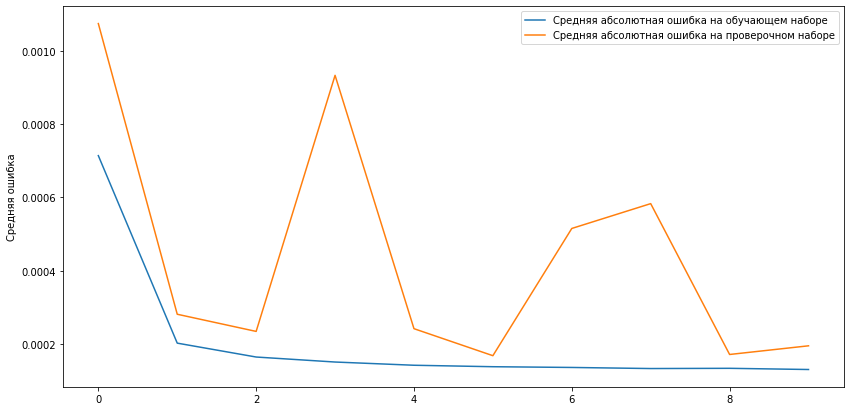

In [ ]:
show_loss(history)

## Предсказанные данные

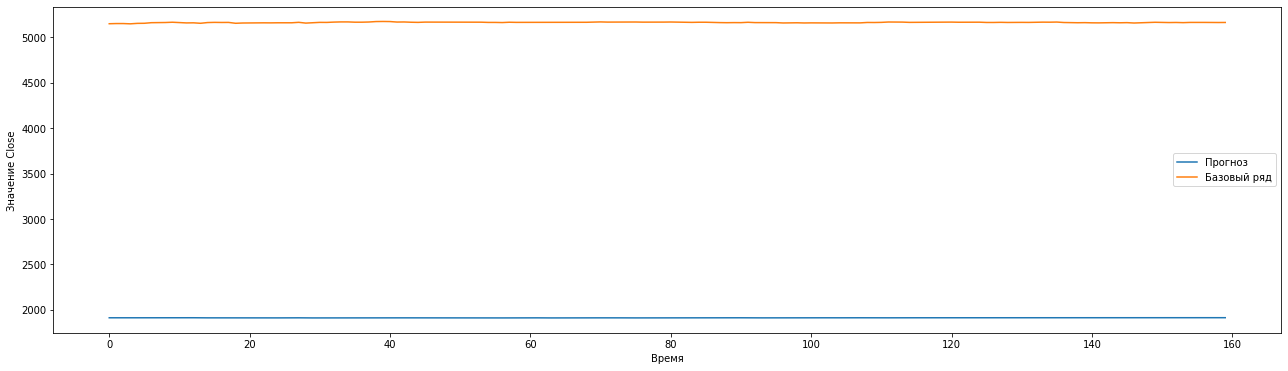

In [ ]:
currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(0, 160, 0, predVal, yValUnscaled)

## Корреляция данных

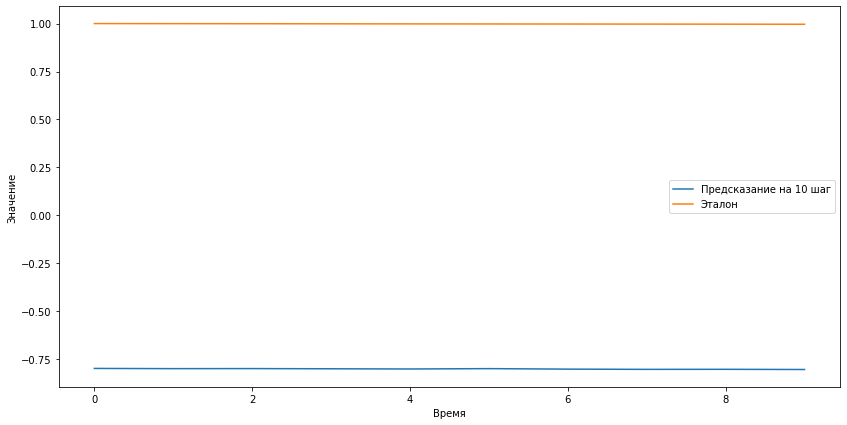

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

# Эксперимент 2 - Полносвязная сеть (только столбец close, на 10 шагов)

In [ ]:
train_data = get_data_few_steps(data, start=10)

# get Datagen for train and test
trainDataGen, testDataGen = train_data[0][0], train_data[0][1]

# get scaler
xScaler, yScaler = train_data[0][2], train_data[0][3]

# get validation data
xVal = train_data[1][0]
yVal = train_data[1][1]

## Обучение модели

In [ ]:
# create new model
model = create_dense_model(steps=10)

# learning model
history = model.fit(
                    trainDataGen, 
                    epochs=10, 
                    verbose=1, 
                    validation_data = testDataGen, 
                    )

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 300, 150)          300       
                                                                 
 flatten_6 (Flatten)         (None, 45000)             0         
                                                                 
 dense_13 (Dense)            (None, 10)                450010    
                                                                 
Total params: 450,310
Trainable params: 450,310
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22579/22579 [==============================] - 275s 12ms/step - loss: 7.3353e-04 - val_loss: 1.7379e-04
Epoch 2/10
22579/22579 [==============================] - 265s 12ms/step - loss: 2.2758e-04 - val_loss: 2.9141e-04
Epoch 3/10
22579/22579 [==============================] - 271s 12ms/step - loss: 1

## График ошибок

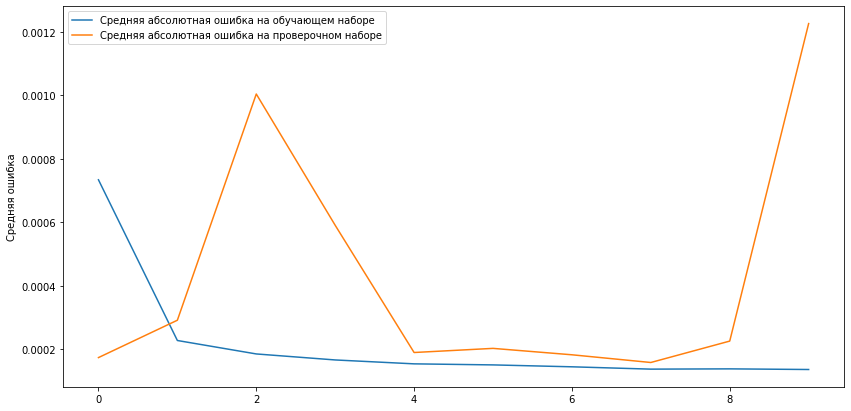

In [ ]:
show_loss(history)

## Предсказанные данные

In [ ]:
predVal = model.predict(xVal[0][:20])

predVal = yScaler.inverse_transform(predVal)

In [ ]:
yVal = yScaler.inverse_transform(yVal[0][:20])

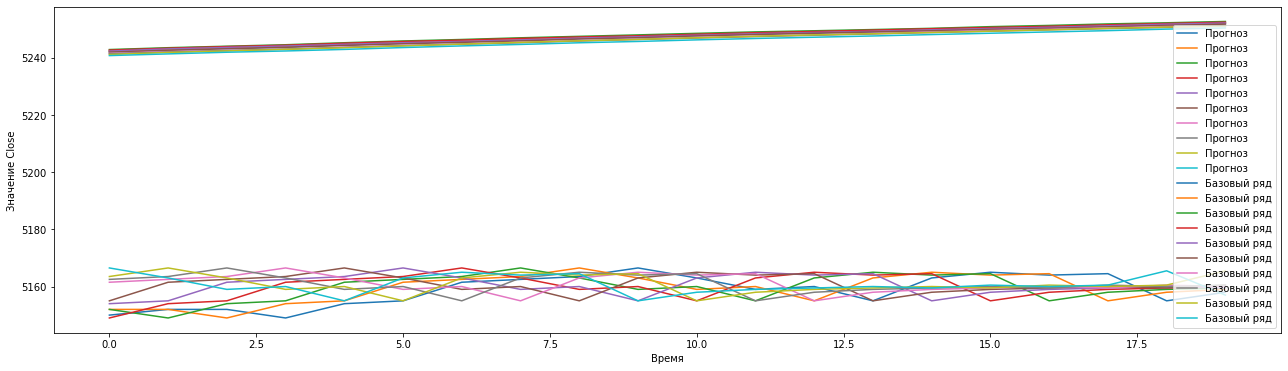

In [ ]:
plt.figure(figsize=(22,6))
plt.plot(predVal,
          label='Прогноз')
plt.plot(yVal, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

# Эксперимент 3 - Сверточная сеть (только столбец close)

In [ ]:
train_data = get_data(data)

# get Datagen for train and test
trainDataGen, testDataGen = train_data[0][0], train_data[0][1]

# get scaler
xScaler, yScaler = train_data[0][2], train_data[0][3]

# get validation data
xVal, yVal = train_data[1][0], train_data[1][1]

## Обучение модели

In [ ]:
# create new model
model = create_conv_model()

# learning model
history = model.fit(
                    trainDataGen, 
                    epochs=10, 
                    verbose=1, 
                    validation_data = testDataGen, 
                    )

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 296, 16)           96        
                                                                 
 conv1d_1 (Conv1D)           (None, 292, 8)            648       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 146, 8)           0         
 )                                                               
                                                                 
 flatten_7 (Flatten)         (None, 1168)              0         
                                                                 
 dense_14 (Dense)            (None, 100)               116900    
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                      

## График ошибок

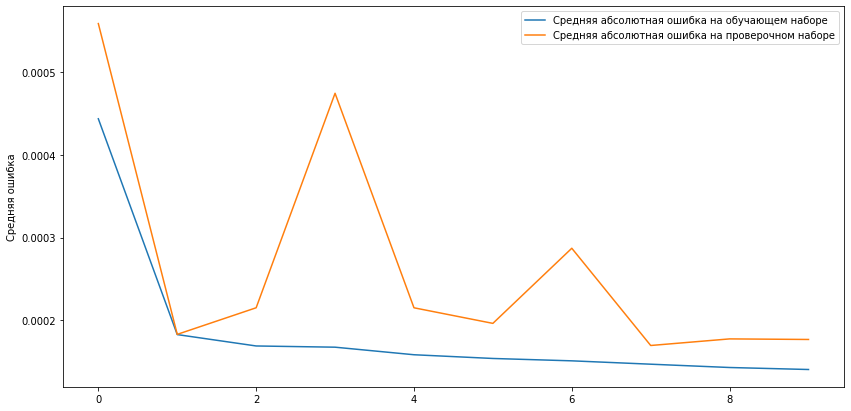

In [ ]:
show_loss(history)

## Предсказанные данные

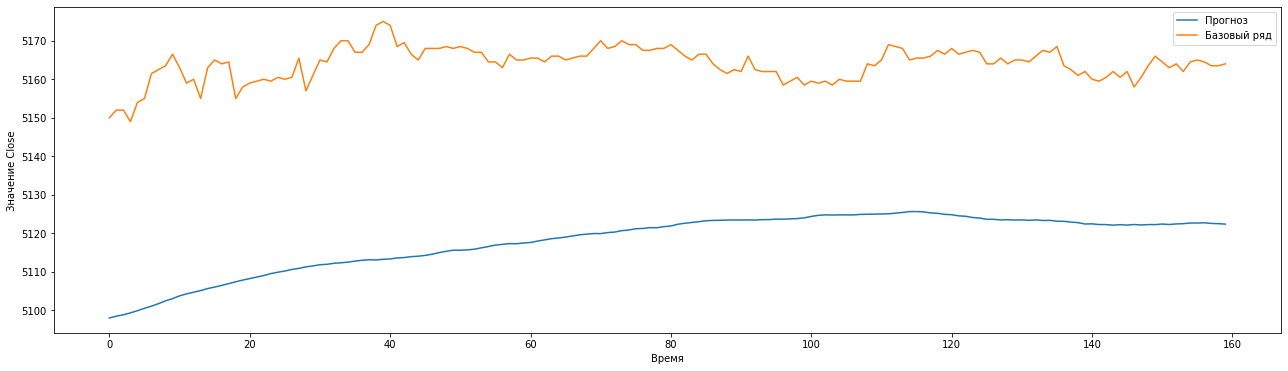

In [ ]:
currModel = model
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(0, 160, 0, predVal, yValUnscaled)

## Корреляция данных

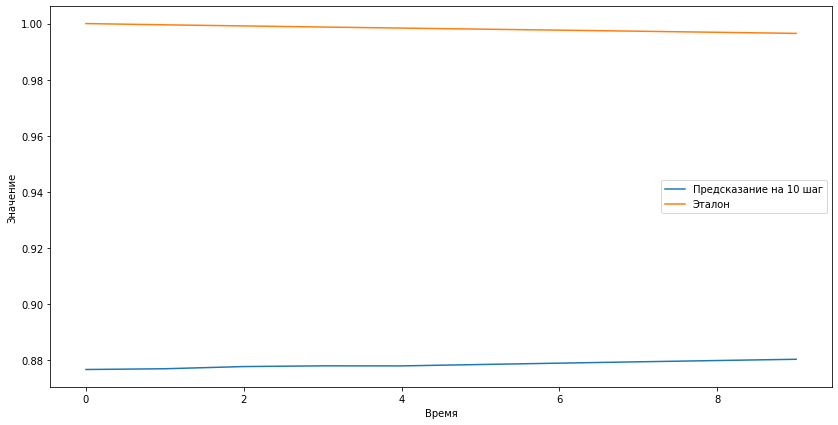

In [ ]:
showCorr([0], 10, predVal, yValUnscaled)

# Эксперимент 4 - Сверточная сеть (только столбец close, на 10 шагов)

In [ ]:
train_data = get_data_few_steps(data, start=10)

# get Datagen for train and test
trainDataGen, testDataGen = train_data[0][0], train_data[0][1]

# get scaler
xScaler, yScaler = train_data[0][2], train_data[0][3]

# get validation data
xVal, yVal = train_data[1][0], train_data[1][1]

## Обучение модели

In [ ]:
# create new model
model = create_conv_model()

# learning model
history = model.fit(
                    trainDataGen, 
                    epochs=10, 
                    verbose=1, 
                    validation_data = testDataGen, 
                    )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 296, 16)           96        
                                                                 
 conv1d_3 (Conv1D)           (None, 292, 8)            648       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 146, 8)           0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 1168)              0         
                                                                 
 dense_16 (Dense)            (None, 100)               116900    
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                      

## График ошибок

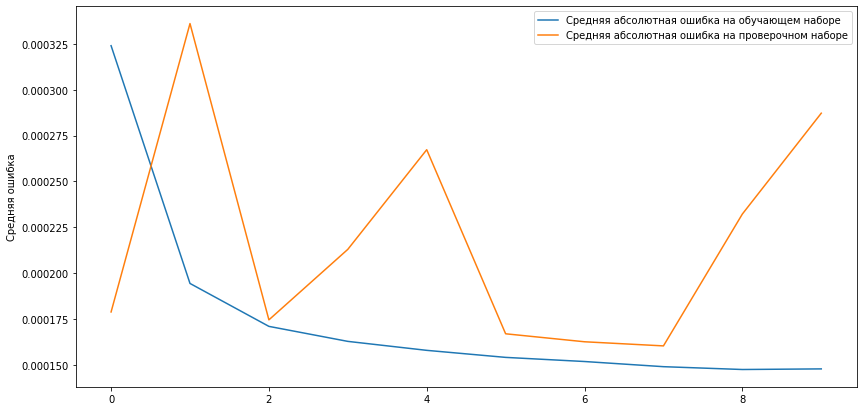

In [ ]:
show_loss(history)

## Предсказанные данные

In [ ]:
predVal = model.predict(xVal[0][:20])

predVal = yScaler.inverse_transform(predVal)

In [ ]:
yVal = yScaler.inverse_transform(yVal[0][:20])

In [ ]:
plt.figure(figsize=(22,6))
plt.plot(predVal,
          label='Прогноз')
plt.plot(yVal, 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()